In [104]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import make_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import cv2
import sys
sys.path.append('../../utils')
import config_handling as conf
from database import Database
from file_io import path_handler
import matplotlib.image as mpimg
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:

# Ensure TensorFlow compatibility for CNN-based feature extraction and classifiers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


2025-01-10 09:02:45.813660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736499765.876164    5509 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736499765.894482    5509 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 09:02:46.031789: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

# Load configuration
config = conf.read_config('../../config/automotive.conf.ini')
config.read('config.ini')
connection_type = config['settings']['connection']
user = config[connection_type]['user']
pw = config[connection_type]['pw']
host = config[connection_type]['host']
db = config[connection_type]['db']
port = config[connection_type].getint('port')
db = Database(host,
              port,
              user,
              pw,
              db
              )
db.connect()


Connection established


In [4]:

# Image directory
basedir = config['settings']['image_directory']


In [5]:

# Define angle tags and their corresponding ordinal positions
ANGLES = ["front", "frontleft", "left", "rearleft", "rear", "rearright", "right", "frontright"]
ORDINAL_MAP = {tag: i for i, tag in enumerate(ANGLES)}


In [6]:

# Penalty matrix based on circular adjacency
PENALTY_MATRIX = np.zeros((len(ANGLES), len(ANGLES)))
for i in range(len(ANGLES)):
    for j in range(len(ANGLES)):
        distance = min(abs(i - j), len(ANGLES) - abs(i - j))
        PENALTY_MATRIX[i, j] = distance


In [16]:

# Function to preprocess image data for CNNs
def preprocess_image(image_path, use_bounding_box=False, bbox=None):
    img = cv2.imread(image_path)
    x1, y1, x2, y2 = bbox
    if use_bounding_box and x1 != x2:
        img = img[y1:y2, x1:x2]
    img = cv2.resize(img, (64, 64))  # Resizing for CNN input
    img = img / 255.0  # Normalize pixel values
    return img


In [17]:

# Load and preprocess labeled data
def load_data(df, use_bounding_boxes=False):
    images = []
    for _, row in tqdm(df.iterrows()):
        bbox = (row['yolobox_top_left_x'], row['yolobox_top_left_y'], row['yolobox_bottom_right_x'], row['yolobox_bottom_right_y'])
        img = preprocess_image(row['abs_image_path'], use_bounding_boxes, bbox)
        images.append(img)
    return np.array(images)


In [9]:

# Binary classifier with CNN
binary_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

binary_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


/home/frederic/Documents/automotive_project/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-10 09:02:48.909388: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:

# Angle classifier with CNN
angle_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(ANGLES), activation='softmax')
])


In [11]:

def bbox_to_ints(df):
    df = df.copy()
    for col in ['yolobox_top_left_x', 'yolobox_top_left_y', 'yolobox_bottom_right_x', 'yolobox_bottom_right_y']:
        df[col] = df[col].astype(int)
    return df

In [12]:

angle_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Query labeled and unlabeled data
tags = db.execute_query("""SELECT image_id, 
                            angle, 
                            images.yolobox_top_left_x, 
                            images.yolobox_top_left_y, 
                            images.yolobox_bottom_right_x, 
                            images.yolobox_bottom_right_y, 
                            images.image_path 
                        FROM angletags 
                        JOIN images on images.id = angletags.image_id 
                        WHERE 
                            manual_annotation = 1""")
labeled_data = pd.DataFrame(tags).fillna(-1)
labeled_data = bbox_to_ints(labeled_data)


In [13]:

untagged = db.execute_query("""SELECT 
                                image_path, 
                                yolobox_top_left_x,
                                yolobox_top_left_y,
                                yolobox_bottom_right_x,
                                yolobox_bottom_right_y
                            FROM images
                            LEFT JOIN angletags on images.id = angletags.image_id
                            WHERE angletags.pk IS NULL
""")
unlabeled_data = pd.DataFrame(untagged).fillna(-1)
unlabeled_data = bbox_to_ints(unlabeled_data)


In [14]:
unlabeled_data["image_path"] = unlabeled_data["image_path"].apply(lambda x: x.replace('\\', '/'))
unlabeled_data["abs_image_path"]= basedir + '/' + unlabeled_data["image_path"]
labeled_data["image_path"] = labeled_data["image_path"].apply(lambda x: x.replace('\\', '/'))
labeled_data["abs_image_path"]= basedir + '/' + labeled_data["image_path"]

In [18]:

# Preprocess labeled and unlabeled data
labeled_images = load_data(labeled_data, use_bounding_boxes=True)
unlabeled_images = load_data(unlabeled_data.sample(200), use_bounding_boxes=True)


4335it [00:09, 444.45it/s]
200it [00:00, 344.66it/s]


In [19]:

# Prepare binary labels
labels = labeled_data['angle'].values
binary_labels = np.where(labels == "crappy", 1, 0)


In [20]:

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(labeled_images, binary_labels, test_size=0.2, random_state=42)


In [21]:

# Train binary classifier
binary_model.fit(X_train_binary, y_train_binary, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.6897 - loss: 0.5829 - val_accuracy: 0.8444 - val_loss: 0.4047
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8804 - loss: 0.3077 - val_accuracy: 0.8991 - val_loss: 0.2827
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9110 - loss: 0.2225 - val_accuracy: 0.9049 - val_loss: 0.2569
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9314 - loss: 0.1906 - val_accuracy: 0.9092 - val_loss: 0.2608
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9482 - loss: 0.1456 - val_accuracy: 0.9135 - val_loss: 0.2413
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9535 - loss: 0.1269 - val_accuracy: 0.9078 - val_loss: 0.2826
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9640 - loss: 0.0983 - val_accuracy: 0.9049 - val_loss: 0.3038
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9760 - loss: 0.0709 - val_accuracy: 0.9135 - v

In [22]:

# Evaluate binary classifier
binary_loss, binary_accuracy = binary_model.evaluate(X_test_binary, y_test_binary)
print(f"Binary Classifier - Loss: {binary_loss}, Accuracy: {binary_accuracy}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9373 - loss: 0.2107
Binary Classifier - Loss: 0.25049901008605957, Accuracy: 0.9273356199264526


In [57]:
binary_cutoff_point = 0.5
# Predict non-crappy images
binary_predictions_unlabeled = binary_model.predict(unlabeled_images)
non_crappy_indices = np.where(binary_predictions_unlabeled < binary_cutoff_point)[0]
non_crappy_images = unlabeled_images[non_crappy_indices]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


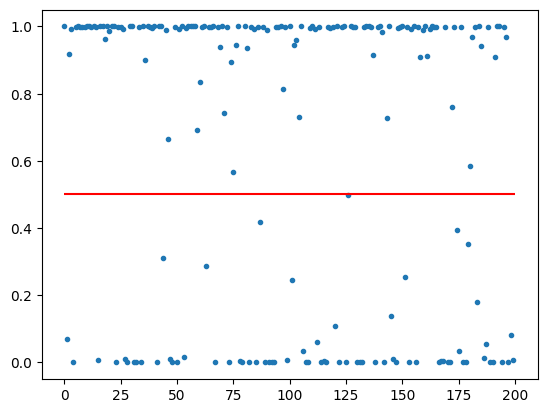

In [72]:
plt.scatter(
    x= range(len(binary_predictions_unlabeled)), 
    y = binary_predictions_unlabeled, 
    marker='.'
    )
plt.hlines(binary_cutoff_point, xmin=0, xmax=len(binary_predictions_unlabeled), color='red')

In [26]:

# Prepare angle labels
not_crappy_mask = labels != "crappy"
angle_labels = labels[not_crappy_mask]
angle_images = labeled_images[not_crappy_mask]


In [83]:

label_encoder = LabelEncoder()
angle_labels_encoded = label_encoder.fit_transform(angle_labels)


In [84]:

# Train angle classifier
X_train_angle, X_test_angle, y_train_angle, y_test_angle = train_test_split(angle_images, angle_labels_encoded, test_size=0.2, random_state=42)


In [85]:

angle_model.fit(X_train_angle, y_train_angle, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9503 - loss: 0.1587 - val_accuracy: 0.8566 - val_loss: 0.5511
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9561 - loss: 0.1444 - val_accuracy: 0.8346 - val_loss: 0.6453
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9503 - loss: 0.1337 - val_accuracy: 0.8382 - val_loss: 0.6273
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9583 - loss: 0.1233 - val_accuracy: 0.8382 - val_loss: 0.7306
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9520 - loss: 0.1459 - val_accuracy: 0.8787 - val_loss: 0.6281
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9578 - loss: 0.0957 - val_accuracy: 0.8566 - val_loss: 0.6689
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9574 - loss: 0.1109 - val_accuracy: 0.8235 - val_loss: 0.6970
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9691 - loss: 0.1014 - val_accuracy: 0.8125 - v

In [86]:

# Evaluate angle classifier
angle_loss, angle_accuracy = angle_model.evaluate(X_test_angle, y_test_angle)
print(f"Angle Classifier - Loss: {angle_loss}, Accuracy: {angle_accuracy}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8635 - loss: 0.9882
Angle Classifier - Loss: 0.9988084435462952, Accuracy: 0.8554572463035583


In [102]:
#visualize a confusion matrix: 
y_test_predictions = angle_model.predict(X_test_angle)
y_test_prediction_labels = np.argmax(y_test_predictions, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [112]:
labels_decoded = label_encoder.inverse_transform(range(8))
labels_decoded

array(['front', 'frontleft', 'frontright', 'left', 'rear', 'rearleft',
       'rearright', 'right'], dtype=object)

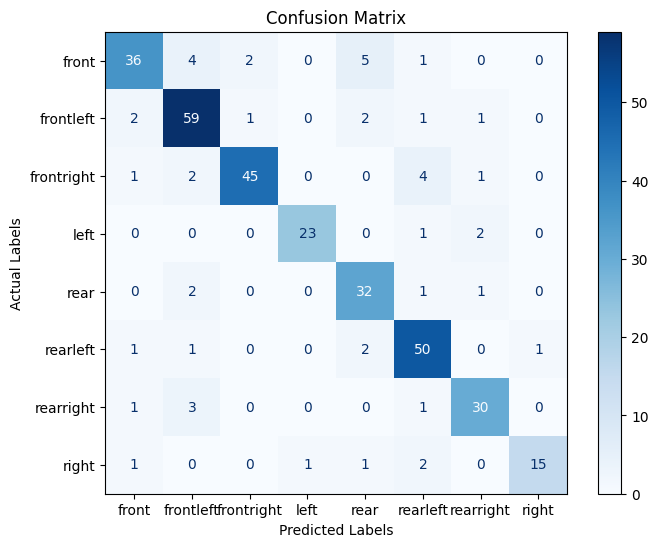

In [113]:
confusion_on_y_test = pd.DataFrame(
    {
        'actuals': y_test_angle,
        'predicts': y_test_prediction_labels
    }
)

#confusion_on_y_test.sample(5)
cm = confusion_matrix(confusion_on_y_test['actuals'], confusion_on_y_test['predicts'], labels=range(8))

# Display confusion matrix using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_decoded)
disp.plot(ax=ax, cmap='Blues', colorbar=True)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

In [31]:

# Predict angles for non-crappy images
predicted_angles = angle_model.predict(non_crappy_images)
predicted_labels = label_encoder.inverse_transform(np.argmax(predicted_angles, axis=1))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [32]:

random_unlabled_data = unlabeled_data.sample(200)
random_unlabled_data["predicted_label"] = "crappy"
random_unlabled_data.iloc[non_crappy_indices, random_unlabled_data.columns.get_loc("predicted_label")] = predicted_labels


In [33]:
random_unlabled_data.sample(10)

,image_path,yolobox_top_left_x,yolobox_top_left_y,yolobox_bottom_right_x,yolobox_bottom_right_y,abs_image_path,predicted_label
1153620,bmw/1 Reeks (alle)/284cbf9f-5947-4783-9535-a3e...,102,167,636,411,/home/frederic/Documents/automotive_image_data...,rearright
7224544,/jeep/Wrangler/ba000628-f171-44cc-b795-ce0ac56...,-1,-1,-1,-1,/home/frederic/Documents/automotive_image_data...,crappy
14864695,/kia/Niro/8186fa55-51de-40cd-9ae5-a87ee62c6745...,-1,-1,-1,-1,/home/frederic/Documents/automotive_image_data...,crappy
409070,ford/Focus/d2ccef6e-efa5-4ccb-8b76-1f22d423c9e...,73,140,619,465,/home/frederic/Documents/automotive_image_data...,crappy
5180711,/mercedes-benz/C-Klasse (alle)/cb8a7672-104e-4...,83,163,649,509,/home/frederic/Documents/automotive_image_data...,crappy
9788281,/citroen/C4 (alle)/1614bec8-c756-4c58-905b-af7...,-1,-1,-1,-1,/home/frederic/Documents/automotive_image_data...,front
7985196,/honda/Civic/05aaa26e-b2e8-44ad-a7ac-ca82c56a7...,-1,-1,-1,-1,/home/frederic/Documents/automotive_image_data...,right
7547532,/land-rover/Discovery Sport/d31d4155-3688-4c3b...,-1,-1,-1,-1,/home/frederic/Documents/automotive_image_data...,frontright
2217422,skoda/Kamiq/dd730619-8489-4ada-9b75-5afec95735...,1,23,750,526,/home/frederic/Documents/automotive_image_data...,rearright
712196,peugeot/206/c9b513fb-4a02-4ee2-8ca3-cd823d1503...,-1,-1,-1,-1,/home/frederic/Documents/automotive_image_data...,frontright
